In [1]:
# main function
import numpy as np
import torch
import matplotlib.pyplot as plt
import botorch

from xopt.bayesian.algorithms import bayesian_exploration

from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

import os
SMOKE_TEST = os.environ.get('SMOKE_TEST')

# test function
from xopt.tests.evaluators import TNK


In [2]:
# To see log messages
from xopt import output_notebook
output_notebook()

In [3]:
"""
    Example where we must use a custom botorch model to make predictions. 
    We modify the test_TNK function with a wrapper to return Nan values for the y1 objective if one of the constraints are not satisfied.
    To accomidate this we define a ModelListGP model as a custom model to remove Nan values from the training data.

"""

# define a new test function that returns nans for y1 if c1 is not valid
def nan_test_TNK(x):
    outputs = TNK.evaluate_TNK(x)
    if outputs['c1'] < 0:
        outputs['y1'] = np.nan
        
    return outputs


# Get VOCS
VOCS = TNK.VOCS
VOCS['objectives'] = {'y1' : None}

# add reference point
ref = torch.tensor((1.4, 1.4))

print(VOCS)
# Get evaluate function
EVALUATE = nan_test_TNK
n_steps = 30
generator_options = {}

if SMOKE_TEST:
    generator_options = {'batch_size': 1,
                           'num_restarts': 2,
                           'raw_samples': 2}
    n_steps = 3


# Run
init_x = torch.tensor([[0.9, 0.9], [0.6, 0.6]])
results = bayesian_exploration(VOCS, EVALUATE,
                               n_initial_samples=5,
                               initial_x=None,
                               n_steps=n_steps,
                               generator_options=generator_options,
                               verbose=True)

{'name': 'TNK_test', 'description': 'Constrainted test function TNK. See Table V in https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf', 'simulation': 'test_TNK', 'variables': {'x1': [0, 3.14159], 'x2': [0, 3.14159]}, 'objectives': {'y1': None}, 'constraints': {'c1': ['GREATER_THAN', 0], 'c2': ['LESS_THAN', 0.5]}, 'constants': {'a': 'dummy_constant'}}
started running optimization with generator: <xopt.bayesian.generators.exploration.BayesianExplorationGenerator object at 0x7fa1d1f8ff40>
submitting initial candidates at time 2021-09-27T22:11:09-07:00
starting optimization loop
submitting candidates at time 2021-09-27T22:11:10-07:00
[tensor([ 0.0816,  0.6724, -1.1862,  1.2262, -0.7940], dtype=torch.float64), tensor([ -2.9574, -10.1570,  -8.3494,  -7.0367,  -2.0914,  -0.7381],
       dtype=torch.float64), tensor([-1.0974,  3.6432,  3.1530,  2.3416, -1.7518, -1.7641],
       dtype=torch.float64)]
submitting candidates at time 2021-09-27T22:11:12-07:00
[tensor([ 0.0816,  0.6724, -1.1862,  1.2262

dict_keys(['variables', 'objectives', 'corrected_objectives', 'constraint_status', 'feasibility', 'model', 'constraints', 'corrected_constraints'])
tensor([[1.4255],
        [1.9555],
        [0.2881],
        [2.4523],
        [0.6400],
        [   nan],
        [   nan],
        [0.3185],
        [0.9881],
        [0.8211],
        [   nan],
        [0.0980],
        [1.0377],
        [0.8745],
        [1.0848],
        [   nan],
        [1.0379],
        [0.4036],
        [1.1021],
        [0.5368],
        [0.6781],
        [1.1732],
        [0.0766],
        [1.0422],
        [0.2850],
        [0.9388],
        [   nan],
        [   nan],
        [0.5520],
        [1.1417],
        [   nan],
        [   nan],
        [0.7528],
        [1.1740],
        [0.3328]], dtype=torch.float64)


Text(0, 0.5, '$x_2$')

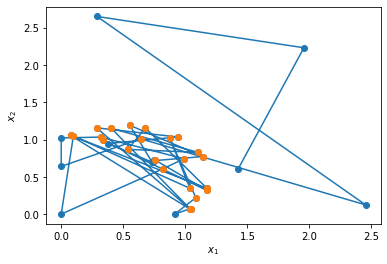

In [4]:
fig, ax = plt.subplots()
print(results.keys())
variables = results['variables']
print(results['objectives'])
valid = results['variables'][results['feasibility'].flatten()]
ax.plot(variables[:, 0], variables[:, 1], '-o')
ax.plot(valid[:, 0], valid[:, 1], 'o')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
